# Machine learning: Predicción de estado de conservación de bombas de agua en Tanzania

## Análisis exploratorio inicial, por Francisco de Asís Borrego Díaz

En este Análisis exploratorio inicial se analiza una pequeña base de datos de bombas de agua públicas creada por el [Ministerio de agua de Tanzania](http://maji.go.tz/) a través de la organización [Taarifa](taarifa.org), donde las bombas pueden encontrarse en tres estados diferentes, funcionales, necesitan reparación o no funcionan. La idea proviene de la competición [Pump it Up: Data Mining the Water Table](https://www.drivendata.org/competitions/7/pump-it-up-data-mining-the-water-table/) de la web [Drivendata](https://www.drivendata.org).

Se dispone de una colección de bombas recolectada por diferentes organizaciones, la colección de datos es de más de 50000 bombas, pero sólo se disponen de datos de estado de unos 10000. Para cada bomba se conocen valores de estado, localización, instalación, edad, tipo y agua disponible.

En este EDA he realizado un análisis de las principales variables, intentando de manera inicial encontrar una relación a priori entre ellas y el estado.

# OBTENCIÓN DE LOS DATOS
DATASETS Y FUENTES ALTERNATIVAS DE DATOS
Incluye aquí una breve descripción del dataset o datasets de los que partirás para poder evaluar tu hipótesis.
También incluye el origen de estos datos y su fuente.

# describe la fuente de tus datos e incluye los links en Markdown

In [1]:
# Includes básicos

import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from funciones import *
import seaborn as sns

In [2]:
# Primer dataset de entrenamiento

# y_train es una lista con dos columnas, id y estado de la bomba
y_train_filename="datos/y_train_data.csv"
df_ytrain=pd.read_csv(y_train_filename)
df_ytrain.info()






<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59400 entries, 0 to 59399
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            59400 non-null  int64 
 1   status_group  59400 non-null  object
dtypes: int64(1), object(1)
memory usage: 928.2+ KB


In [3]:
# x_train es una lista con los datos de cada bomba, sin el estado.
x_train_filename="datos/x_train_data.csv"
df_xtrain=pd.read_csv(x_train_filename)
df_xtrain.shape

(59400, 40)

In [4]:
# segundo dataset que se usará en el proceso de machine learning

x_test_filename="datos/x_test_data.csv"
df_xtest=pd.read_csv(x_test_filename)
df_xtest.shape

(14850, 40)

In [5]:
# Fusionamos nuestras dos primeras bases de datos
df_train=df_xtrain.set_index("id").join(df_ytrain,how="inner")
df_train.shape
df_train["status_group"].value_counts()


functional                 25912
non functional             18148
functional needs repair     3432
Name: status_group, dtype: int64

In [6]:
# Fusionamos nuestras dos primeras bases de datos
df_test=df_xtest.set_index("id").join(df_ytrain,how="inner")
df_test["status_group"].value_counts()

functional                 6347
non functional             4676
functional needs repair     885
Name: status_group, dtype: int64

In [7]:
# Comprobamos valores duplicados.

df_train.drop_duplicates(inplace=True)

In [8]:
# Valores inválidos
valores_nulos_show(df_train)
# Se observa que sólo aparecen valores nulos en las columnas de tipo texto

tipo datos  valores nulos  % nulos
funder                object           2896     6.10
installer             object           2912     6.13
subvillage            object            310     0.65
public_meeting        object           2638     5.55
scheme_management     object           3126     6.58
scheme_name           object          22503    47.38
permit                object           2439     5.14

In [9]:
df_train=fill_object_nan(df_train)
valores_nulos_show(df_train)    
# introducimos el texto "unkonwn" en cada uno de esos valores únicos

Empty DataFrame
Columns: [tipo datos, valores nulos, % nulos]
Index: []

In [10]:
df_train.dtypes.value_counts()

object     31
int64       7
float64     3
dtype: int64

## Análisis de columnas numéricas

In [11]:
df_train.describe()

# Tenemos 3 coordenadas de posición (x,y,z) en el mapa, 2 coordenadas de localización política, una inútil (num_private), una de población alrededor, otra de año de construcción
# y una técnica (amount_tsh). Se puede obtener también la fecha, desde donde viene la fecha de registro, pero no es útil.

amount_tsh    gps_height     longitude      latitude   num_private  \
count   47492.000000  47492.000000  47492.000000  4.749200e+04  47492.000000   
mean      321.619839    670.483113     34.073900 -5.709289e+00      0.483450   
std      3058.875078    694.169168      6.574296  2.940334e+00     13.101459   
min         0.000000    -90.000000      0.000000 -1.164944e+01      0.000000   
25%         0.000000      0.000000     33.085868 -8.538572e+00      0.000000   
50%         0.000000    372.000000     34.910935 -5.017494e+00      0.000000   
75%        25.000000   1321.000000     37.178734 -3.330187e+00      0.000000   
max    350000.000000   2770.000000     40.345193 -2.000000e-08   1776.000000   

        region_code  district_code    population  construction_year  \
count  47492.000000   47492.000000  47492.000000       47492.000000   
mean      15.331719       5.648783    180.113472        1302.240777   
std       17.660861       9.674385    477.018150         951.131485   
min        1.000000       0.000000      0.000000           0.000000   
25%        5.000000       2.000000      0.000000           0.000000   
50%       12.000000       3.000000     25.000000        1986.000000   
75%       17.000000       5.000000    213.000000        2004.000000   
max       99.000000      80.000000  30500.000000        2013.000000   

                 id  
count  47492.000000  
mean   37103.406553  
std    21495.186288  
min        0.000000  
25%    18442.750000  
50%    37031.500000  
75%    55734.750000  
max    74247.000000

In [12]:
# Introducimos columnas de información para el date recorded.
df_train["date_recorded"]=pd.to_datetime(df_train['date_recorded'],format="%Y-%m-%d")
df_train["date_recorded_year"]=df_train["date_recorded"].dt.year
df_train["date_recorded_month"]=df_train["date_recorded"].dt.month

In [13]:
# Establecemos 1999 como año de cosntrucción de aquellos bombas que no se conocen.
df_train.construction_year=np.where(df_train.construction_year>0,df_train.construction_year,1999)
cuenta_valores_per(df_train,"construction_year",True)

                   valores_unicos       media
construction_year              54  879.481481


In [14]:
df_train.population=np.where(df_train.population>0,df_train.population,round(np.median(df_train.population.loc[df_train.population>0].mean()),0))
cuenta_valores_per(df_train,"population",True)

            valores_unicos      media
population             981  48.411825


In [15]:
# Agrupamos todas las variables categóricas.
resumen_tipos_unicos(df_train,tipos_col(df_train)["obj"])

valores_unicos  porcentaje_mayor_valor
funder                         1694.0               15.269940
installer                      1912.0               29.438642
wpt_name                      30643.0                6.015750
basin                             9.0               17.051293
subvillage                    17260.0                0.861198
region                           21.0                8.980460
lga                             125.0                4.268087
ward                           2084.0                0.530616
public_meeting                    3.0               85.780763
recorded_by                       1.0              100.000000
scheme_management                13.0               61.820938
scheme_name                    2536.0               47.382717
permit                            3.0               65.419439
extraction_type                  18.0               45.072854
extraction_type_group            13.0               45.072854
extraction_type_class             7.0               45.072854
management                       12.0               68.163059
management_group                  5.0               88.457003
payment                           7.0               42.617704
payment_type                      7.0               42.617704
water_quality                     8.0               85.660743
quality_group                     6.0               85.660743
quantity                          5.0               55.811505
quantity_group                    5.0               55.811505
source                           10.0               28.566917
source_type                       7.0               28.566917
source_class                      3.0               76.975069
waterpoint_type                   7.0               48.027036
waterpoint_type_group             6.0               58.279289
status_group                      3.0               54.560768

In [16]:
for col in tipos_col(df_train)["obj"]:
    df_train[col] = agrupa_categoricas(df_train,col,9,0)

resumen_tipos_unicos(df_train,tipos_col(df_train)["obj"])

valores_unicos  porcentaje_mayor_valor
funder                           10.0               59.024678
installer                        10.0               51.669755
wpt_name                         10.0               86.591426
basin                             9.0               17.051293
subvillage                       10.0               94.723322
region                           10.0               39.524552
lga                              10.0               80.556725
ward                             10.0               96.593110
public_meeting                    3.0               85.780763
recorded_by                       1.0              100.000000
scheme_management                10.0               61.820938
scheme_name                      10.0               47.382717
permit                            3.0               65.419439
extraction_type                   9.0               45.072854
extraction_type_group             9.0               45.072854
extraction_type_class             7.0               45.072854
management                        9.0               68.163059
management_group                  5.0               88.457003
payment                           7.0               42.617704
payment_type                      7.0               42.617704
water_quality                     8.0               85.660743
quality_group                     6.0               85.660743
quantity                          5.0               55.811505
quantity_group                    5.0               55.811505
source                            9.0               28.566917
source_type                       7.0               28.566917
source_class                      3.0               76.975069
waterpoint_type                   7.0               48.027036
waterpoint_type_group             6.0               58.279289
status_group                      3.0               54.560768

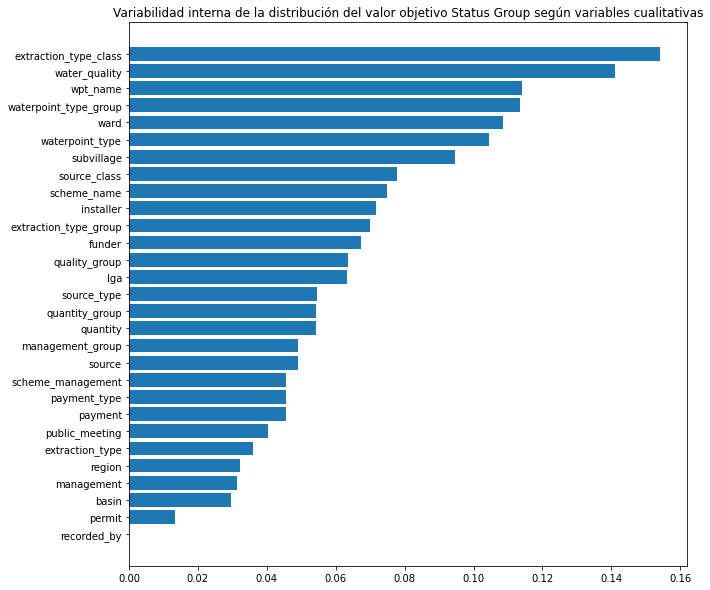

In [17]:
figura=variabilidad(df_train,"status_group").transpose().sort_values(by="status_group")
plt.figure(figsize=[10,10])
plt.barh(figura.index, figura.status_group)
plt.title("Variabilidad interna de la distribución del valor objetivo Status Group según variables cualitativas")
plt.show()

## Estudio de las variables
 Muchas de las variables son redundantes. Referirse al EDA_ampliado donde está detallado una por una.

## 1. id

Es una variable con números de identificación

## 2. amount_tsh

amount_tsh - Total static head (o altura estática del pozo). Indica la presión del agua (imagen)

<AxesSubplot:xlabel='status_group', ylabel='amount_tsh'>

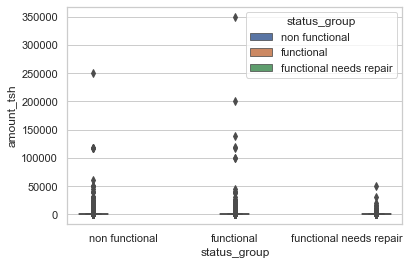

In [18]:
sns.set_theme(style="whitegrid")
sns.boxplot(data=df_train, hue="status_group", x="status_group" ,y="amount_tsh")

In [19]:
df_train["amount_tsh"].describe()

count     47492.000000
mean        321.619839
std        3058.875078
min           0.000000
25%           0.000000
50%           0.000000
75%          25.000000
max      350000.000000
Name: amount_tsh, dtype: float64

## 3. date_recorded

Fecha en que introdujo el registro en la base de datos. No será relevante

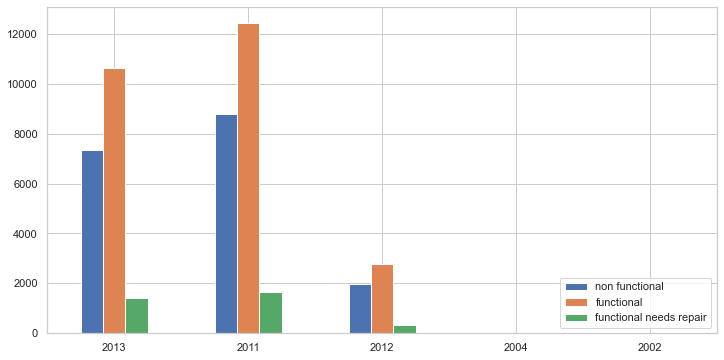

In [20]:
plot_bar_cat(df_train,"date_recorded_year","status_group",12,6,False)

## 4. funder

Quién instaló el pozo

In [21]:
cuenta_valores_per(df_train,"funder")

        valores_unicos   media
funder              10  4749.2


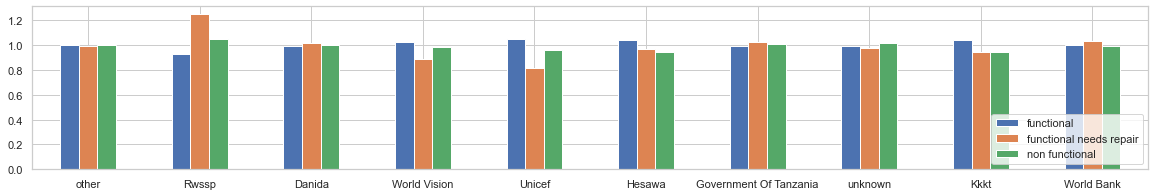

In [22]:
plot_bar_cat(df_train,"funder","status_group",20,3,True)
# Rwssp muestra mayor frecuencia a necesitar reparaciones.

## 6 installer

quién instaló el conjunto de datos

In [23]:
cuenta_valores_per(df_train,"installer")

           valores_unicos   media
installer              10  4749.2


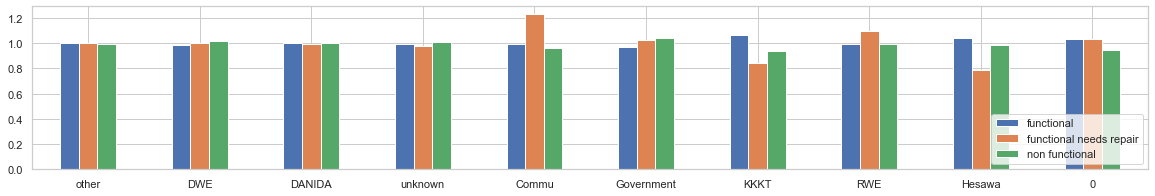

In [24]:
plot_bar_cat(df_train,"installer","status_group",20,3,True)
# Commu muestra mayor frecuencia a necesitar reparaciones. Hesawa menos.

7. longiture, latitude

coordenadas de los pozos. Muchos pozos no poseen datos de posición

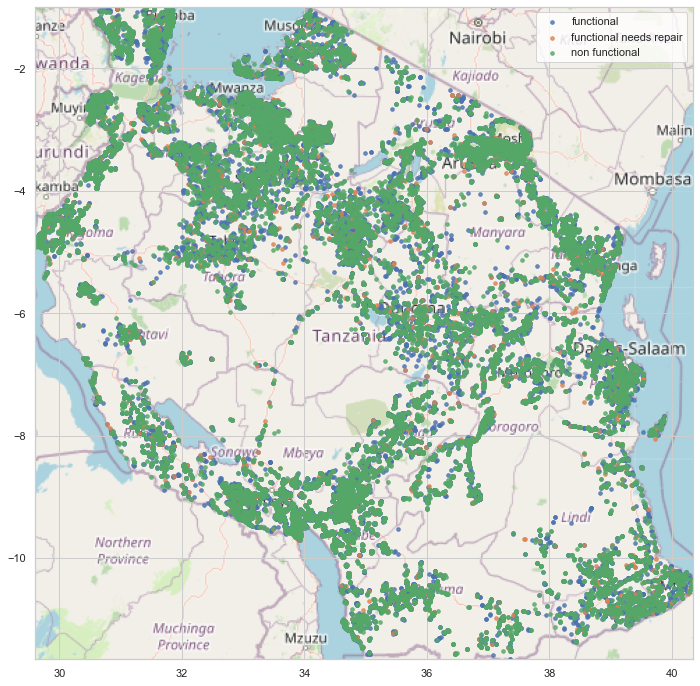

In [25]:
grafica_tanzania(df_train,"OSM_tz_mapa.png","status_group")
# A priori no parece haber patrón en la posición de los pozos y el estado.

## 5. GPS height

altura del gps en metros

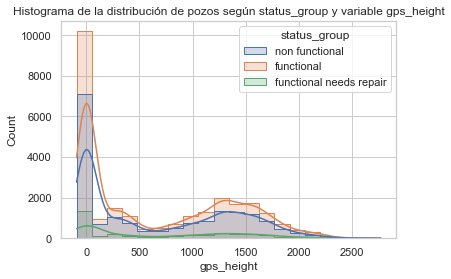

In [26]:
hist_var(df_train,"status_group","gps_height")

<AxesSubplot:xlabel='status_group', ylabel='gps_height'>

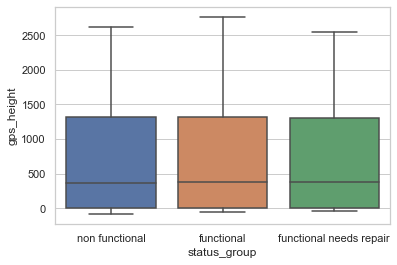

In [27]:
sns.boxplot(data=df_train,  x="status_group" ,y="gps_height")
# No parece haber relación

## 9 wpt_name

Nombre del pozo si es que tiene uno

In [29]:
cuenta_valores_per(df_train,"wpt_name")
# No es útil.

          valores_unicos   media
wpt_name              10  4749.2


## 11 basin

A qué fuente de agua pertenece el pozo

In [30]:
cuenta_valores_per(df_train,"basin")

       valores_unicos        media
basin               9  5276.888889


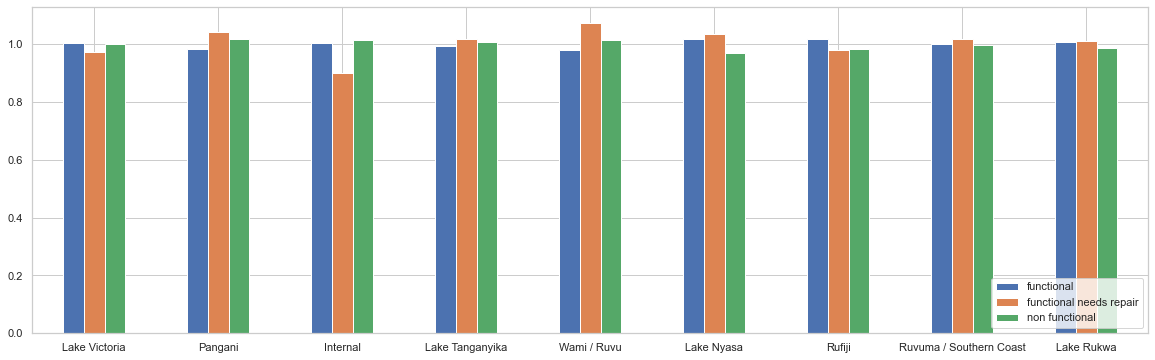

In [31]:
plot_bar_cat(df_train,"basin","status_group",20,6, True)

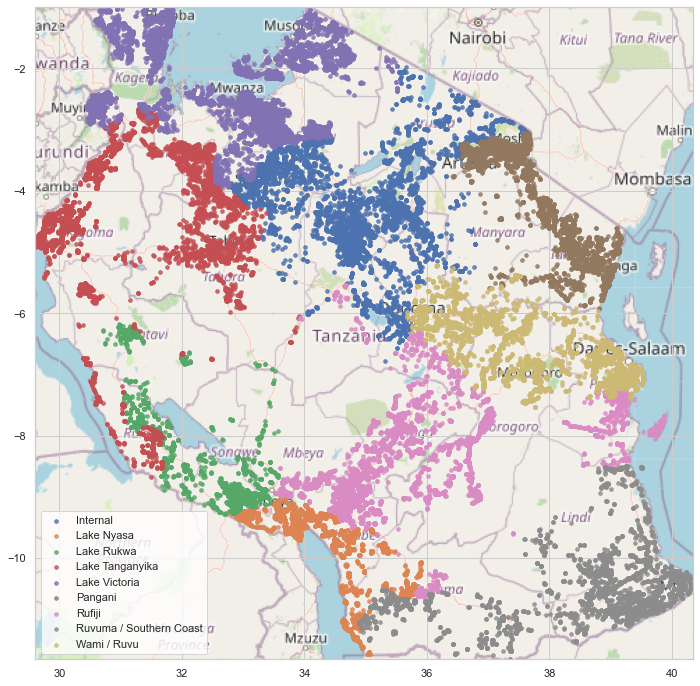

In [32]:
grafica_tanzania(df_train,"OSM_tz_mapa.png","basin")
# Es un valor puramente geográfico. No será relevante.

Subvillage, region, region code, district code, lga y ward son relativos a la localización. se ignorarán.

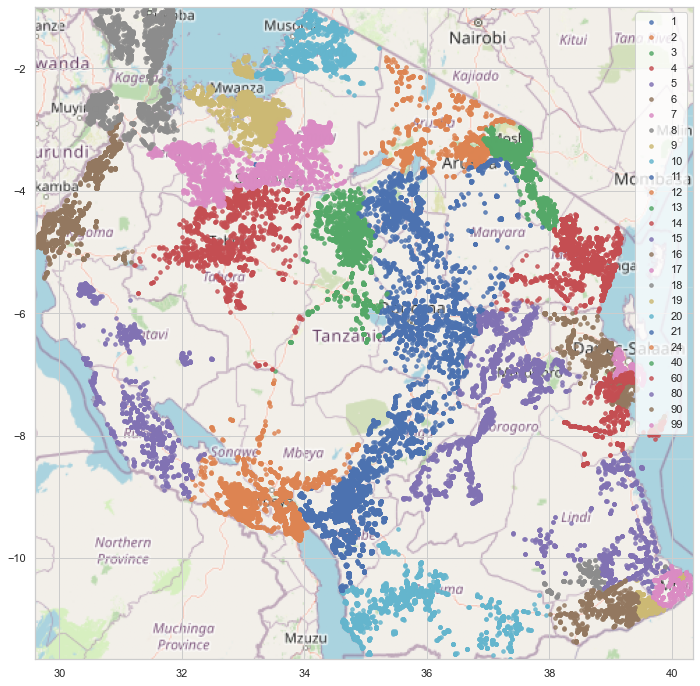

In [33]:
grafica_tanzania(df_train,"OSM_tz_mapa.png","region_code")

## 18 population - 

Population around the well 

Podría ser interesante para ver si hay relación. Podría crearse hasta una medida extra de "población*años instalado" y comparar con el descarte


In [34]:
df_train["population"].describe()
# La mitad de los pozos sólo sirven a 20 personas o menos. Esto podría indicar si están averiados o no.

count    47492.000000
mean       281.142592
std        457.531223
min          1.000000
25%        100.000000
50%        281.000000
75%        281.000000
max      30500.000000
Name: population, dtype: float64

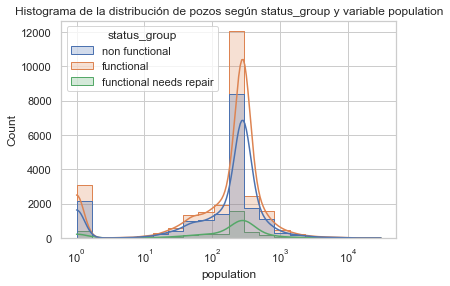

In [35]:
#sns.histplot(x=df_train['population'],log_scale=False, kde=True) 
hist_var(df_train,"status_group","population",bins=20,modo_seaborn=True,log_scale=True)

## 19 public_meeting

Columna booleana. No tengo claro qué significa. La mayoría de valores son ciertos.

In [36]:
cuenta_valores_per(df_train,"public_meeting",False)

total          %
True     40739  85.780763
False     4115   8.664617
unknown   2638   5.554620

In [37]:
tabl_contingencia(df_train,"public_meeting","status_group",False)

non functional  functional  functional needs repair
unknown            1020        1445                      173
True              15556       22199                     2984
False              1572        2268                      275

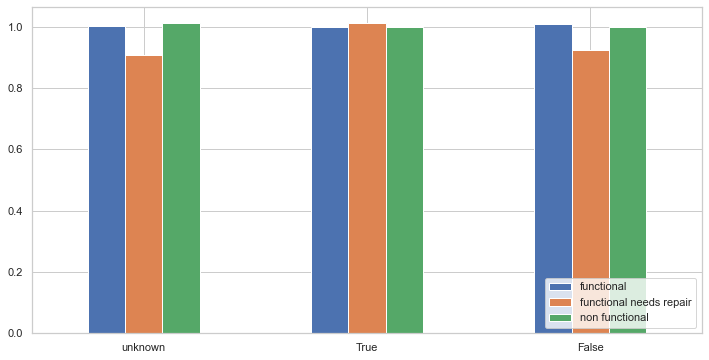

In [38]:
plot_bar_cat(df_train,"public_meeting","status_group",12,6,True)

## 21 scheme management

Quién instaló la bomba

In [39]:
cuenta_valores_per(df_train,"scheme_management",False)

total          %
VWC               29360  61.820938
WUG                4209   8.862545
unknown            3126   6.582161
Water authority    2543   5.354586
WUA                2301   4.845027
Water Board        2196   4.623937
Parastatal         1329   2.798366
Private operator    863   1.817148
Company             829   1.745557
other               736   1.549735

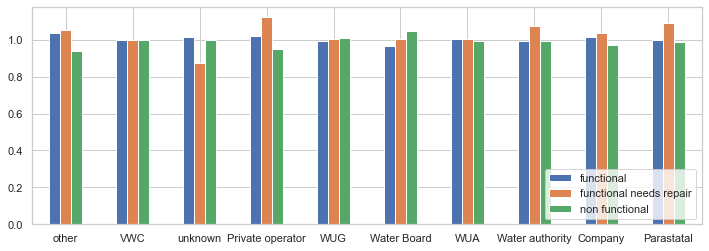

In [40]:
plot_bar_cat(df_train,"scheme_management","status_group",12,4,True)

## 23 permit 
- Si se permite el pozo

In [41]:
cuenta_valores_per(df_train,"permit",False)

total          %
True     31069  65.419439
False    13984  29.444959
unknown   2439   5.135602

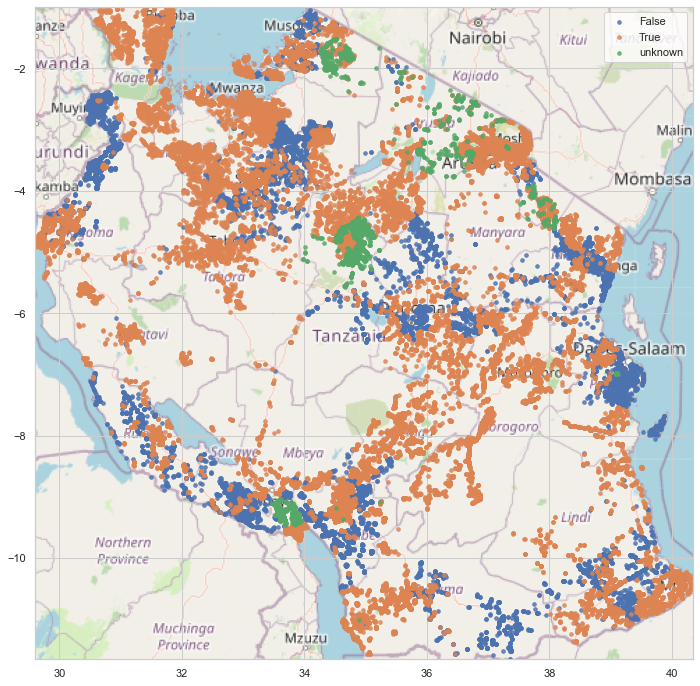

In [42]:
grafica_tanzania(df_train,"OSM_tz_mapa.png","permit")
# Se observa de nuevo que los puntos tienen fuerte dependencia de la localización. No parece a prioru ser interesante.

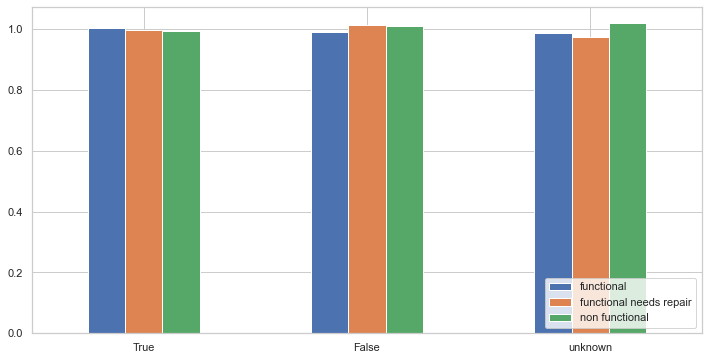

In [43]:
plot_bar_cat(df_train,"permit","status_group",12,6,True)
# No parece haber especial incidencia

## 24 construction_year 
- Year the waterpoint was constructed

In [44]:
cuenta_valores_per(df_train,"construction_year")

                   valores_unicos       media
construction_year              54  879.481481


## 25 extraction_type 
- The kind of extraction the waterpoint uses

In [45]:
cuenta_valores_per(df_train,"extraction_type",False)

total          %
gravity        21406  45.072854
nira/tanira     6582  13.859176
other           6114  12.873747
submersible     3799   7.999242
swn 80          2913   6.133665
mono            2293   4.828182
india mark ii   1884   3.966984
afridev         1376   2.897330
ksb             1125   2.368820

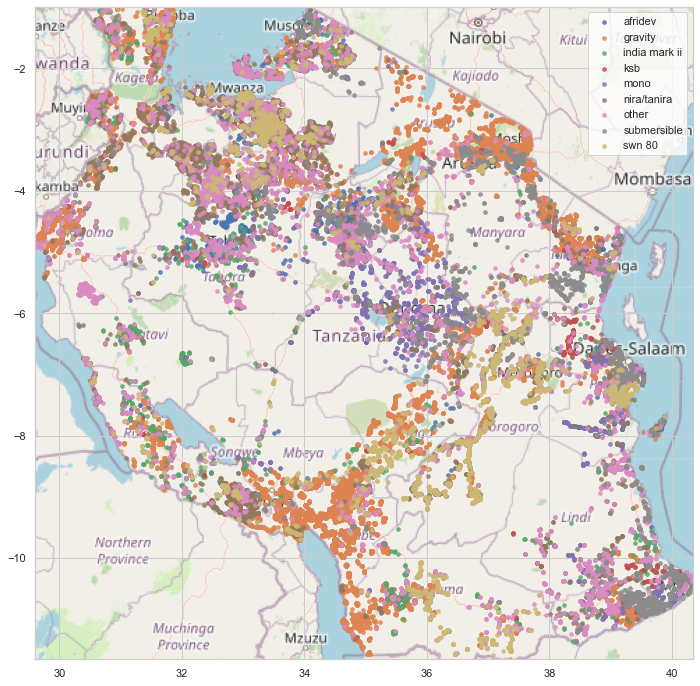

In [46]:
grafica_tanzania(df_train,"OSM_tz_mapa.png","extraction_type")

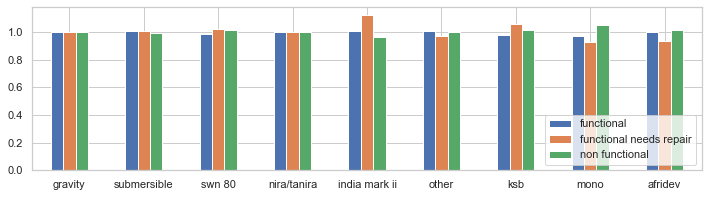

In [47]:
plot_bar_cat(df_train,"extraction_type","status_group",12,3,True)

## 27. extraction_type_class - The kind of extraction the waterpoint uses

8 valores. Este tipo puede ser interesante.

In [48]:
cuenta_valores_per(df_train,"extraction_type_class")

                       valores_unicos        media
extraction_type_class               7  6784.571429


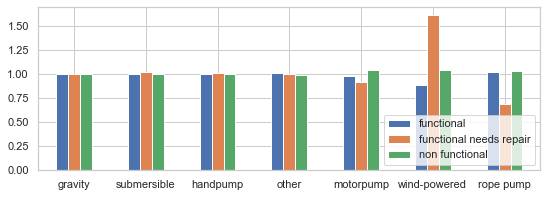

In [49]:
plot_bar_cat(df_train,"extraction_type_class","status_group",9,3,True)

## 28. management - How the waterpoint is managed
Este valor al estar reducido puede ser interesante, pero la mayoría de valores pertenecen a vwc.

In [50]:
cuenta_valores_per(df_train,"management")

            valores_unicos        media
management               9  5276.888889


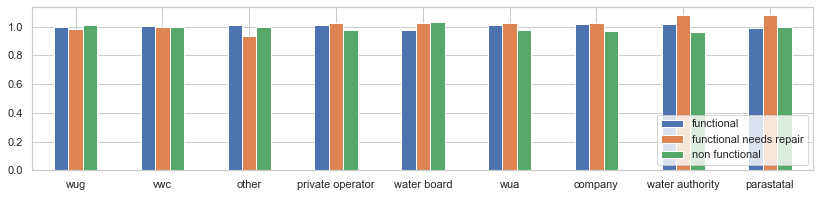

In [51]:
plot_bar_cat(df_train,"management","status_group",14,3,True)

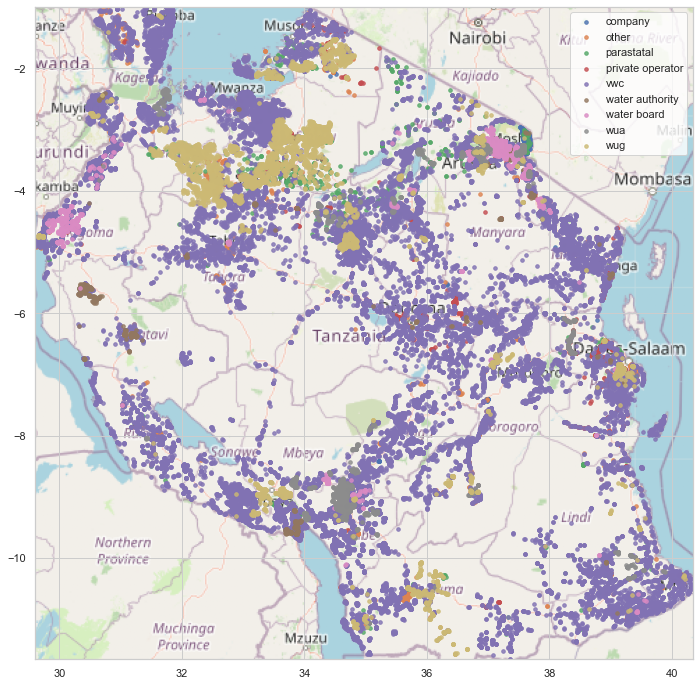

In [52]:
grafica_tanzania(df_train,"OSM_tz_mapa.png","management")
# Fuerte dependencia de la región en aquellos valores que no son "company"

## 30. payment - What the water costs
## 31. payment_type - What the water costs

Son iguales. No muestra a priori mucha relevancia.

In [53]:
cuenta_valores_per(df_train,"payment")

         valores_unicos        media
payment               7  6784.571429


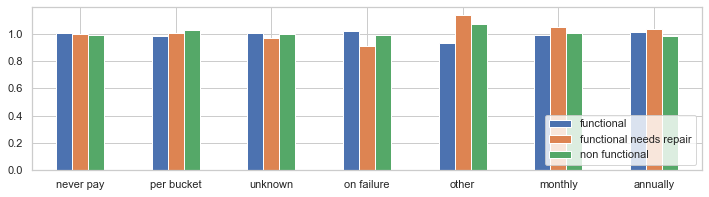

In [54]:
plot_bar_cat(df_train,"payment_type","status_group",12,3,True)

## 32. water_quality - The quality of the water
El 85% de los pozos son de tipo blando. Mejor usar quality_group

In [55]:
cuenta_valores_per(df_train,"water_quality")

               valores_unicos   media
water_quality               8  5936.5


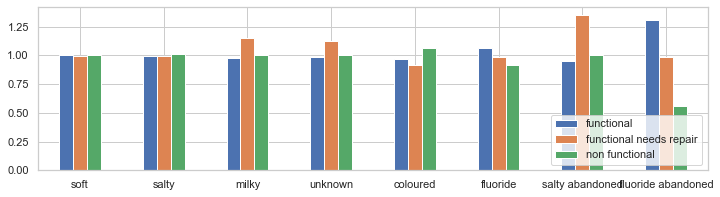

In [56]:
plot_bar_cat(df_train,"water_quality","status_group",12,3,True)
# Fluoride abandoned es testimonial por su escasa presencia. Por esta razón se emplea el siguiente grupo.

## 33. quality_group - The quality of the water

Este grupo es igual que water_quality, pero reune los dos de flouride. Es preferible

In [57]:
cuenta_valores_per(df_train,"quality_group")

               valores_unicos        media
quality_group               6  7915.333333


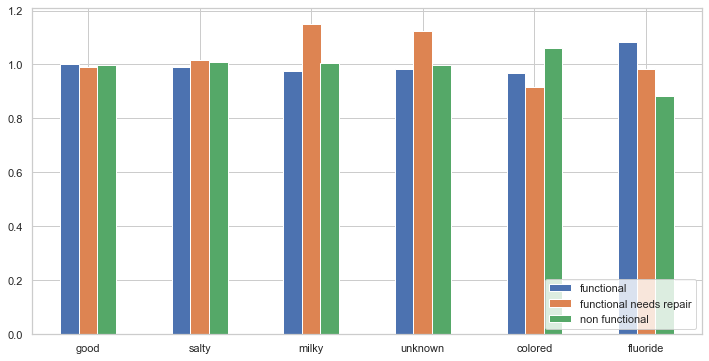

In [58]:
plot_bar_cat(df_train,"quality_group","status_group",12,6,True)

## 34. quantity - The quantity of water
## 35. quantity_group - The quantity of water
Ambos indican si la cantidad de agua es suficiente en una variable categórica. son la misma variable.

In [59]:
cuenta_valores_per(df_train,"quantity_group")

                valores_unicos   media
quantity_group               5  9498.4


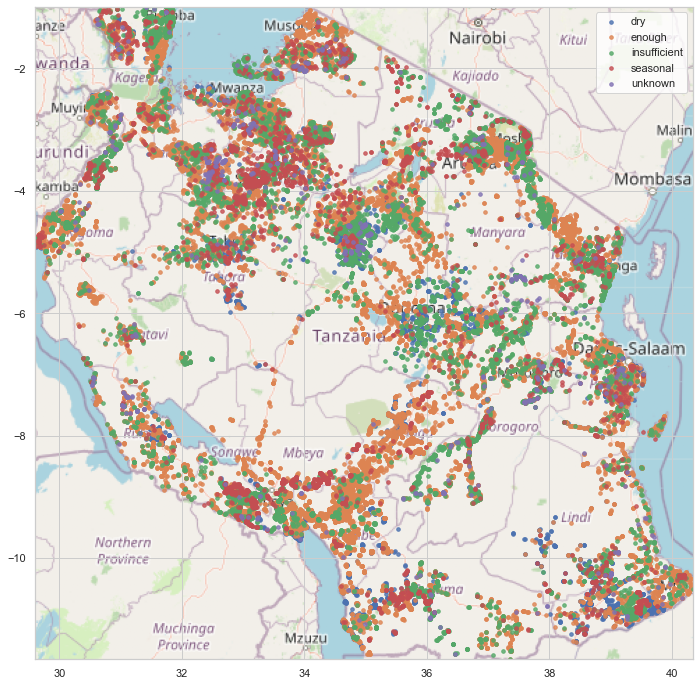

In [60]:
grafica_tanzania(df_train,"OSM_tz_mapa.png","quantity_group")

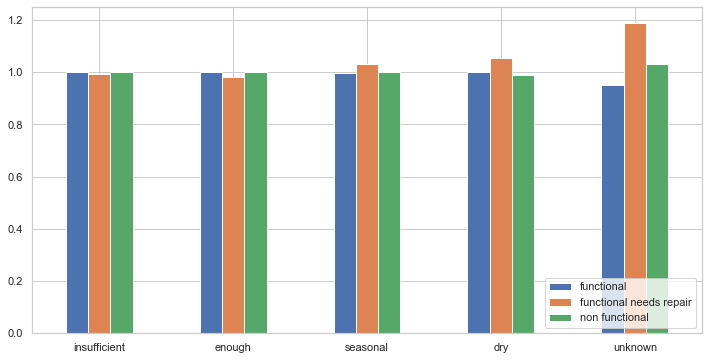

In [61]:
plot_bar_cat(df_train,"quantity_group","status_group",12,6,True)

## 36. source - The source of the water
## 37 soruce_type (mejor que el anterior)
## 38. source_class - The source of the water (Este indica que si es subterranea o superficie. Viene de source.)

In [62]:
cuenta_valores_per(df_train,"source")

        valores_unicos        media
source               9  5276.888889


In [63]:
cuenta_valores_per(df_train,"source_type")

             valores_unicos        media
source_type               7  6784.571429


In [64]:
cuenta_valores_per(df_train,"source_class")

              valores_unicos         media
source_class               3  15830.666667


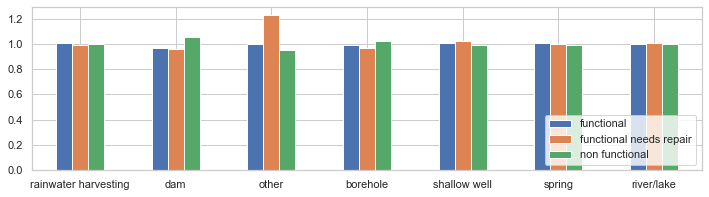

In [65]:
plot_bar_cat(df_train,"source_type","status_group",12,3,True)

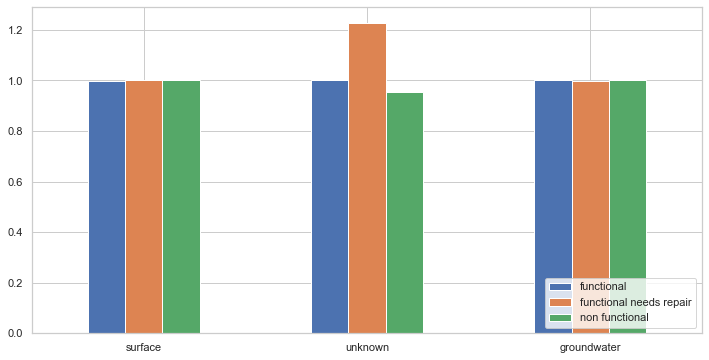

In [66]:
plot_bar_cat(df_train,"source_class","status_group",12,6,True)

## 39. waterpoint_type - The kind of waterpoint
## 40. waterpoint_type_group - The kind of waterpoint (Éste es mejor)
La variable indica el tipo de tecnología del pozo

In [67]:
cuenta_valores_per(df_train,"waterpoint_type_group")

                       valores_unicos        media
waterpoint_type_group               6  7915.333333


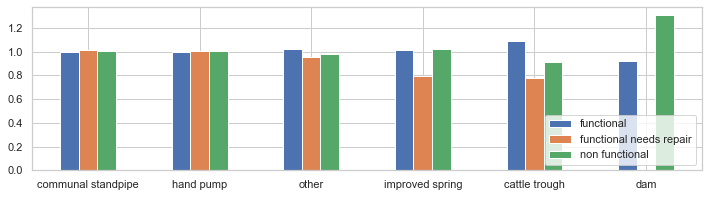

In [68]:
plot_bar_cat(df_train,"waterpoint_type_group","status_group",12,3,True)

# Resulmen de variables relevantes
De texto.

List:
    40. waterpoint_type (tecnología de pozos, 5 tipos)
    38. source_type
    35. quality_group
    33. quantity_group
    31. payment_type
    27. extraction_type_class (tecnología de extracción)
    24. construcion_year
    23. permit
    22. scheme_name
    11-17 valores relativos a la localización. No son relevantes
    4. funder (quién instaló)
    6. installer (organización que instaló)

Numéricas
['amount_tsh', 2. Cantidad de agua dsponible
 'gps_height', 5. Altura en metros
 'longitude', 6- latitud
 'latitude', 7. longitud
 'region_code',  de localización, es categórico
 'district_code', de localización, es categórico
 'population', 18. Población alrededor. La mayoría son cero.
 'construction_year', 24. FEcha construcción-
 'id', clave
 'edad_years', Derivados del valor 24.
 'date_recorded_year',
 'date_recorded_month']
    

In [70]:
lista_numericas=['amount_tsh', 'gps_height', 
'longitude', 
'latitude',
'population', 
'construction_year']

lista_categoricas=["waterpoint_type","source_type","quality_group","quantity_group","payment_type","extraction_type_class","permit","scheme_name","funder","installer"]

 # Realmente no hay apenas variables numéricas a priori interesantes. La mayoría del trabajo se hará con las variables categóricas

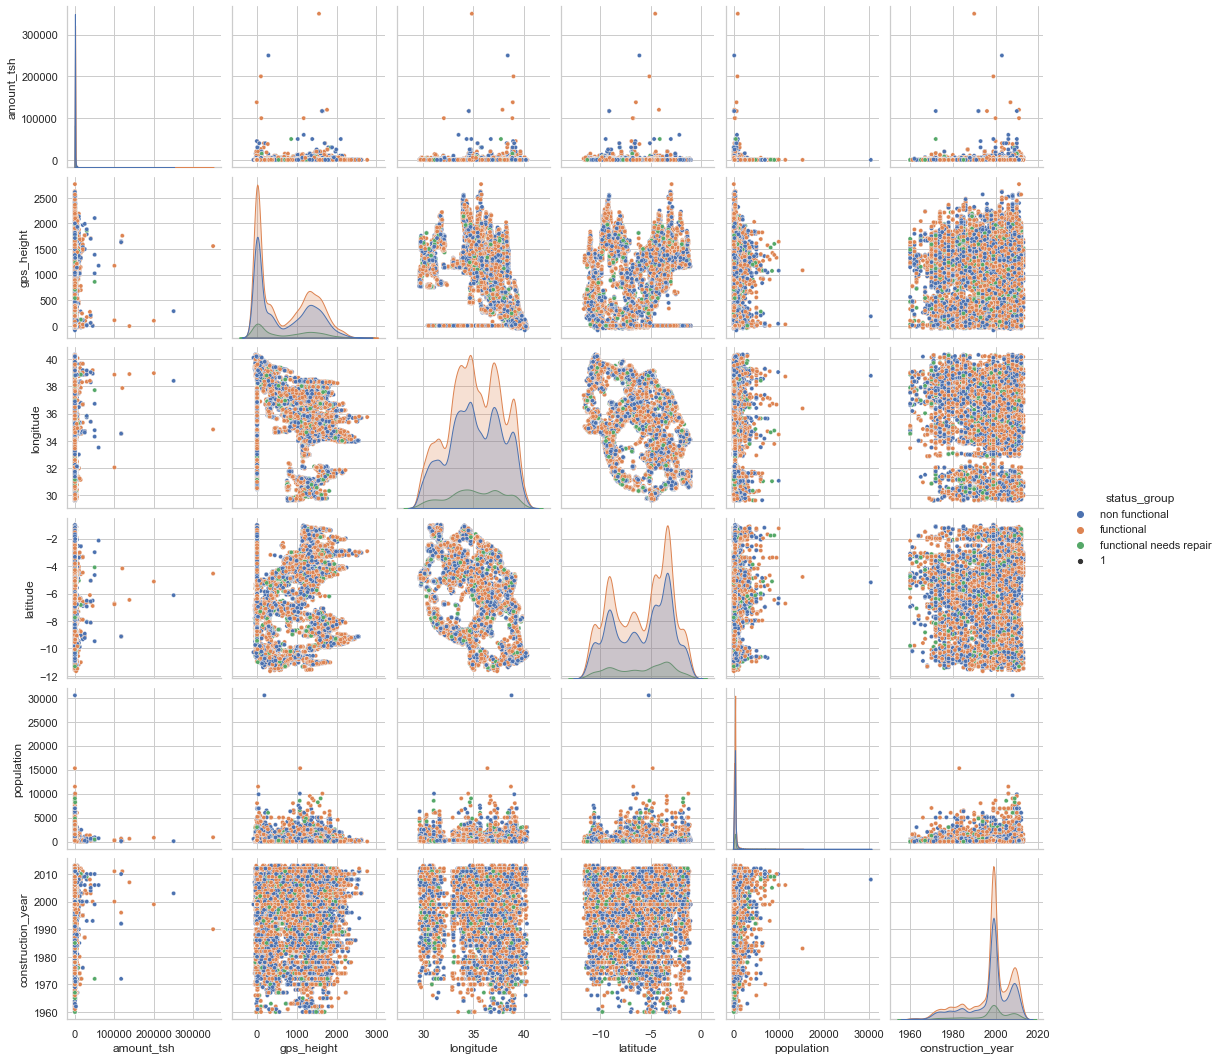

In [73]:
df_train_local=df_train.loc[df_train["longitude"]!=0]
sns.pairplot(data=df_train_local, vars=lista_numericas, hue="status_group" ,plot_kws={'size':1})

# No se deduce nada especial.